In [7]:
import pandas as pd
import glob
import json
import seaborn as sns
import tarfile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [8]:
# decompress 'data.tar'gz'

# with tarfile.open("data_finalized.tar.gz", "r:gz") as tar:
#     tar.extractall()

paths = glob.glob('data_finalized/**/paths.json', recursive=True)
properties = glob.glob('data_finalized/**/properties.json', recursive=True)

df_paths = pd.DataFrame([json.load(open(file)) for file in paths])
df_properties = pd.DataFrame([json.load(open(file)) for file in properties])

# remove data folder

# shutil.rmtree('data')

In [9]:
df = pd.merge(df_paths, df_properties, on='name')

df["path_count"] = df["paths"].apply(lambda x: len(x))
df["pairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if y["pairable"]]))
df["unpairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if not y["pairable"]]))
df["min_permanent"] = df["pathsdetailed"].apply(lambda x: min([y["permanent"] for y in x]))
df["max_permanent"] = df["pathsdetailed"].apply(lambda x: max([y["permanent"] for y in x]))

print(f'There are {df.query("pairable & min_permanent < 0").shape[0] / df.query("pairable").shape[0]:.1%} of pairable paths with negative permanents!')

There are 37.7% of pairable paths with negative permanents!


/Users/Julien/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[Text(0.5, 0, 'Number of pairable paths'), Text(0, 0.5, 'Conductance')]

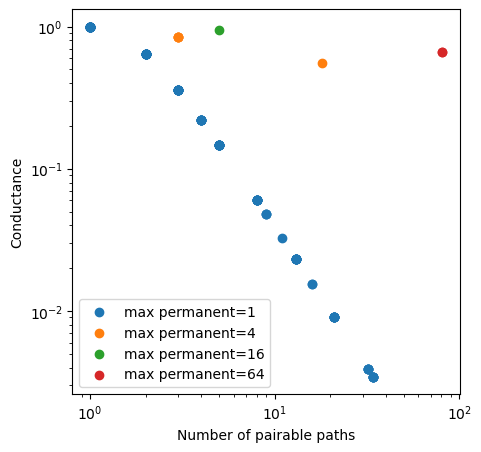

In [11]:
def f(x, a, b):
    # c = 1 - a
    # return a * np.exp(-b * x) + (1 - a)
    return a * x**(-b)

fig, ax = plt.subplots(figsize=(5, 5))
for max_permanent in [1, 4, 16, 64]:
    df_temp = df.query("max_permanent == @max_permanent & min_permanent >= 0")
    x = df_temp["pairablepath_count"].values
    y = df_temp["conductance"].values
    if len(df_temp) == 0:
        continue
    ax.scatter(x, y, label=f"max permanent={max_permanent}")
    if len(df_temp) > 1:
        popt, pcov = curve_fit(f, x, y)
        X = np.linspace(x.min(), x.max(), 100)
        Y = f(X, *popt)
        # ax.plot(X, Y, label=f"$y={popt[0]:.2f}\\exp(-{popt[1]:.2f}x)$")
    
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set(xlabel='Number of pairable paths', ylabel='Conductance')

In [29]:
def adjavancy_perm(M: np.ndarray):
    sum = 0
    for i1 in range(M.shape[0]):
        for j1 in range(M.shape[1]):
            if M[i1, j1] == 0:
                continue
            for i2 in range(i1+1, M.shape[0]):
                for j2 in range(j1+1, M.shape[1]):
                    if M[i2, j2] == 0:
                        continue
                    sum += 1
    return sum

def perm(M, max_complexity: int) -> float:
    n = M.shape[0]
    complexity = n * 2**n
    if complexity > max_complexity:
        return -1
    d = np.ones(n)
    j =  0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n-1):
        v -= 2*d[j]*M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s*prod
        f[0] = 0
        f[j] = f[j+1]
        f[j+1] = j+1
        j = f[0]
    return p/2**(n-1)


In [30]:
M = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])
print(M)
print(adjavancy_perm(M))

[[1 0 1]
 [0 1 0]
 [1 0 1]]
3


In [36]:
M = np.loadtxt("data_finalized/junction_10234930/adjacancy.txt")
# perm = 64

In [37]:
perm(M, max_complexity=100000000)

0.0

In [38]:
np.linalg.det(M)

0.0